In [1]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import extri_intri_to_pose_encoding, pose_encoding_to_extri_intri
import argparse
import numpy as np
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_root)

from training.data.datasets.nuscenes import NuScenesDataset
from types import SimpleNamespace


/users/PAS2099/jasonzhangggg/.conda/envs/vggt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = "/users/PAS2099/jasonzhangggg/vggt/training/data/nuscenes"
VERSION = "v1.0-mini"
SPLIT = "train"

print(f"Dataset configuration:")
print(f"  Root: {DATA_ROOT}")
print(f"  Version: {VERSION}")
print(f"  Split: {SPLIT}")

USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"Using device: {device}")

Dataset configuration:
  Root: /users/PAS2099/jasonzhangggg/vggt/training/data/nuscenes
  Version: v1.0-mini
  Split: train
Using device: cuda


In [3]:
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device).eval()

In [4]:
common_conf = SimpleNamespace(
    debug=False,
    training=False,  # Set to False for testing
    get_nearby=False,
    load_depth=False,
    inside_random=False,
    allow_duplicate_img=False,
    img_size=518,
    patch_size=14,
    augs=SimpleNamespace(
        scales=[1.0, 1.0]
    ),
    rescale=True,  # Enable rescaling for proper preprocessing
    rescale_aug=False,
    landscape_check=True
)

dataset = NuScenesDataset(
    common_conf=common_conf,
    split="train",
    NUSCENES_DIR=DATA_ROOT,
    version="v1.0-mini",
)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.198 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
sample = dataset.get_data(seq_index=0)

print("\n=== Sample Info ===")
print(f"Images shape: {sample['images'].shape}")         # [6, H, W, 3]
print(f"Extrinsics shape: {sample['extrinsics'].shape}") # [6, 4, 4]
print(f"Intrinsics shape: {sample['intrinsics'].shape}") # [6, 3, 3]
print(f"Point masks shape: {sample['point_masks'].shape}") # [6, H, W, 1]
print(f"Image pixel range: {sample['images'].min():.2f} → {sample['images'].max():.2f}")


=== Sample Info ===
Images shape: (6, 518, 518, 3)
Extrinsics shape: (6, 3, 4)
Intrinsics shape: (6, 3, 3)
Point masks shape: (6, 518, 518, 1)
Image pixel range: 0.00 → 255.00


In [6]:
images = torch.from_numpy(sample['images']).permute(0, 3, 1, 2).float()  # [6, 3, H, W]
images = images.unsqueeze(0)  # [1, 6, 3, H, W]

gt_ext = torch.from_numpy(sample['extrinsics']).float()  # [6, 4, 4]
gt_int = torch.from_numpy(sample['intrinsics']).float()  # [6, 3, 3]

if images.max() > 1.0:
    images = images / 255.0

In [8]:
def standardize_quaternion(quaternions: torch.Tensor) -> torch.Tensor:
    """
    Convert a unit quaternion to a standard form: one in which the real
    part is non negative.

    Args:
        quaternions: Quaternions with real part last,
            as tensor of shape (..., 4).

    Returns:
        Standardized quaternions as tensor of shape (..., 4).
    """
    return torch.where(quaternions[..., 3:4] < 0, -quaternions, quaternions)
    
def compare_pose_encodings(pred_pose_enc, gt_pose_enc):
    """
    Compare predicted and ground truth pose encodings.
    
    Pose encoding format (9D):
    [0:3] - Translation (x, y, z)
    [3:7] - Rotation as quaternion (w, x, y, z)
    [7:9] - Field of view (horizontal, vertical)
    """
    print("\n" + "="*80)
    print("POSE ENCODING COMPARISON")
    print("="*80)
    
    
    # Compare each component
    trans_pred = pred_pose_enc[:, 0:3]
    trans_gt = gt_pose_enc[:, 0:3]
    trans_error = np.linalg.norm(trans_pred - trans_gt, axis=1)
    
    rot_pred = standardize_quaternion(pred_pose_enc[:, 3:7])
    rot_gt = standardize_quaternion(gt_pose_enc[:, 3:7])
    rot_error_pos = (rot_pred - rot_gt).norm(dim=-1)
    rot_error_neg = (rot_pred + rot_gt).norm(dim=-1)
    print(rot_error_pos)
    rot_error = np.minimum(rot_error_pos, rot_error_neg)
    
    fov_pred = pred_pose_enc[:, 7:9]
    fov_gt = gt_pose_enc[:, 7:9]
    fov_error = np.abs(fov_pred - fov_gt)
    
    print("\n📐 Translation Error (L2 norm per camera):")
    for i in range(len(trans_error)):
        print(f"  Camera {i}: {trans_error[i]:.6f}")
    print(f"  Mean: {trans_error.mean():.6f}, Max: {trans_error.max():.6f}")
    
    print("\n🔄 Rotation Error (L2 norm per camera):")
    for i in range(len(rot_error)):
        print(f"  Camera {i}: {rot_error[i]:.6f}")
    print(f"  Mean: {rot_error.mean():.6f}, Max: {rot_error.max():.6f}")
    
    print("\n📷 FoV Error (per camera):")
    for i in range(len(fov_error)):
        print(f"  Camera {i}: H={fov_error[i,0]:.6f}, V={fov_error[i,1]:.6f}")
    print(f"  Mean: {fov_error.mean():.6f}, Max: {fov_error.max():.6f}")
    
    # Check if coordinate systems match
    print("\n🔍 Coordinate System Check:")
    print("  First camera should be identity (reference frame)")
    print(f"  GT Translation [0]: {trans_gt[0]}")
    print(f"  GT Rotation [0]: {rot_gt[0]}")
    print(f"  Pred Translation [0]: {trans_pred[0]}")
    print(f"  Pred Rotation [0]: {rot_pred[0]}")

    for i in range(6):
        print("\n🔍 Coordinate System Check:")
        print("  First camera should be identity (reference frame)")
        print(f"  Translation cam {i}")
        for k in range(len(trans_gt[i])):
            print(f"     GT: {trans_gt[i][k]}, Pred: {trans_pred[i][k]}")
        print(f"  Rotation cam {i}")
        for k in range(len(rot_gt[i])):
            print(f"     GT: {rot_gt[i][k]}, Pred: {rot_pred[i][k]}")


In [9]:
print(f"  Images: {images.shape}, range: [{images.min():.3f}, {images.max():.3f}]")

# Encode GT extrinsics and intrinsics to pose encoding
print("\n=== Encoding Ground Truth ===")
image_hw = torch.tensor([sample['images'].shape[1], sample['images'].shape[2]])

gt_pose_encoding = extri_intri_to_pose_encoding(
    gt_ext.unsqueeze(0),  # [1, 6, 4, 4]
    gt_int.unsqueeze(0),  # [1, 6, 3, 3]
    image_hw,
    pose_encoding_type="absT_quaR_FoV"
)  # [1, 6, 9]

print(f"✓ GT pose encoding shape: {gt_pose_encoding.shape}")
print(f"\nGT pose encoding (first 2 cameras):")
print(f"  Camera 0: {gt_pose_encoding[0, 0].numpy()}")
print(f"  Camera 1: {gt_pose_encoding[0, 1].numpy()}")

# Load VGGT model
print("\n=== Loading VGGT Model ===")

model.eval()
model = model.to(device)
images = images.to(device)

print(f"✓ Model loaded on {device}")

# Run inference
print("\n=== Running VGGT Inference ===")
with torch.no_grad():
    agg_tokens, ps_idx = model.aggregator(images)

# Get predicted pose encoding
pred_pose_enc = model.camera_head(agg_tokens)[-1]


# Compare predictions with ground truth
errors = compare_pose_encodings(pred_pose_enc[0].detach().cpu(), gt_pose_encoding[0])

print("\n✓ Test completed successfully!")

  Images: torch.Size([1, 6, 3, 518, 518]), range: [0.000, 1.000]

=== Encoding Ground Truth ===
✓ GT pose encoding shape: torch.Size([1, 6, 9])

GT pose encoding (first 2 cameras):
  Camera 0: [-6.3317407e-17 -4.4408921e-16  2.2204460e-16  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  6.1886156e-01
  6.1886156e-01]
  Camera 1: [ 4.1865909e-01 -3.2309433e-03 -2.9181340e-01 -3.2874560e-03
  4.6047422e-01 -5.6264311e-04  8.8766682e-01  6.3299108e-01
  6.3299108e-01]

=== Loading VGGT Model ===
✓ Model loaded on cuda

=== Running VGGT Inference ===

POSE ENCODING COMPARISON
tensor([3.0717e-04, 9.2879e-02, 9.6289e-03, 1.8857e+00, 6.3250e-02, 1.7903e-02])

📐 Translation Error (L2 norm per camera):
  Camera 0: 0.000528
  Camera 1: 0.650947
  Camera 2: 0.496450
  Camera 3: 1.006201
  Camera 4: 0.424732
  Camera 5: 0.711736
  Mean: 0.548432, Max: 1.006201

🔄 Rotation Error (L2 norm per camera):
  Camera 0: 0.000307
  Camera 1: 0.092879
  Camera 2: 0.009629
  Camera 3: 0.135986
  

In [9]:
pred_ext, pred_int = pose_encoding_to_extri_intri(pred_pose_enc, images.shape[-2:])
pred_ext = pred_ext.squeeze(0).detach().cpu().numpy()
pred_ext.shape

(6, 3, 4)

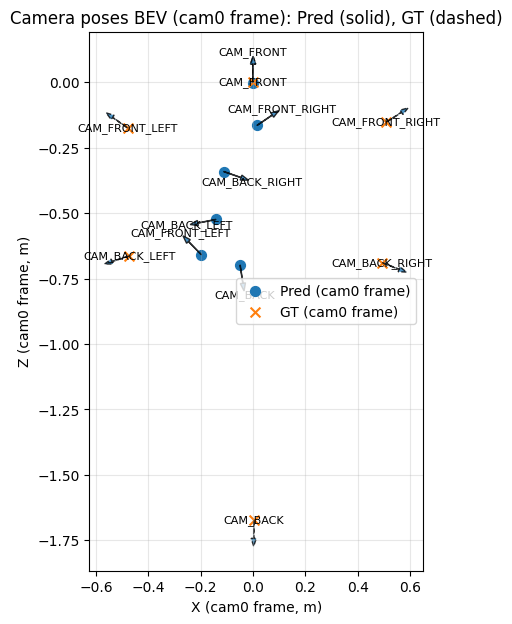

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Camera poses BEV (cam0 frame): Pred (solid), GT (dashed)'}, xlabel='X (cam0 frame, m)', ylabel='Z (cam0 frame, m)'>)

In [13]:
cam_names = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
             'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']

plot_bev_from_pose_encoding(pred_ext, gt_ext, cam_names, skip_first=False)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def mat34_to_Rt(E):
    return E[:, :3], E[:, 3]
    
def _to_numpy(x):
    import torch
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def center_in_input_frame(E):
    R, t = mat34_to_Rt(E)
    return -R.T @ t

# Camera forward (+Z) expressed in the input frame of E.
def forward_in_input_frame(E):
    R, _ = mat34_to_Rt(E)
    ez = np.array([0.0, 0.0, 1.0], dtype=np.float64)
    return R.T @ ez
    
def _quat_wxyz_to_R(q):
    """
    q: (...,4) quaternion in [w, x, y, z], assumed normalized (or close).
    returns: (...,3,3) rotation matrix
    """
    w, x, y, z = q[...,0], q[...,1], q[...,2], q[...,3]
    # normalize just in case
    norm = np.sqrt(w*w + x*x + y*y + z*z) + 1e-8
    w, x, y, z = w/norm, x/norm, y/norm, z/norm

    ww, xx, yy, zz = w*w, x*x, y*y, z*z
    wx, wy, wz = w*x, w*y, w*z
    xy, xz, yz = x*y, x*z, y*z

    R = np.stack([
        np.stack([1-2*(yy+zz), 2*(xy-wz),     2*(xz+wy)    ], axis=-1),
        np.stack([2*(xy+wz),   1-2*(xx+zz),   2*(yz-wx)    ], axis=-1),
        np.stack([2*(xz-wy),   2*(yz+wx),     1-2*(xx+yy)  ], axis=-1),
    ], axis=-2)  # (...,3,3)
    return R

def plot_bev_from_pose_encoding(Ext_pred, Ext_gt_rel, cam_names,
                                skip_first=True, scale=0.1, show_gt=True):
    """
    pred_pose_enc, gt_pose_enc: (N, 9) where
      0:3 = translation (in cam0 frame), 3:7 = quaternion [w,x,y,z] of cam_k wrt cam0,
      7:9 = fov (unused here).
    cam_names: list[str] of length N
    skip_first: skip plotting cam0 (index 0)
    scale: arrow length scale in meters
    show_gt: whether to overlay GT points/arrows (green)

    Returns (fig, ax)
    """
    N = Ext_pred.shape[0]
    idxs = list(range(0, N))
    centers_pred = np.array([center_in_input_frame(E) for E in Ext_pred])
    centers_gt   = np.array([center_in_input_frame(E) for E in Ext_gt_rel])
    fwd_pred     = np.array([forward_in_input_frame(E) for E in Ext_pred])
    fwd_gt       = np.array([forward_in_input_frame(E) for E in Ext_gt_rel])

    fig, ax = plt.subplots(figsize=(7,7))

    # Points
    ax.scatter(centers_pred[idxs,0], centers_pred[idxs,2], label='Pred (cam0 frame)', s=50)
    if show_gt:
        ax.scatter(centers_gt[idxs,0], centers_gt[idxs,2], label='GT (cam0 frame)', s=50, marker='x')

    # Arrows + labels
    for k in idxs:
        cp, fp = centers_pred[k], fwd_pred[k]
        ax.arrow(cp[0], cp[2], fp[0]*scale, fp[2]*scale, alpha=0.8,
                 head_width=0.02, length_includes_head=True)
        # Label near the tip of the pred arrow
        lx = cp[0] + fp[0]*scale*1.15
        ly = cp[2] + fp[2]*scale*1.15
        ax.text(lx, ly, cam_names[k], fontsize=8, ha='center', va='center')

        if show_gt:
            cg, fg = centers_gt[k], fwd_gt[k]
            ax.arrow(cg[0], cg[2], fg[0]*scale, fg[2]*scale, alpha=0.8,
                     head_width=0.02, length_includes_head=True, linestyle='--')

            ax.text(cg[0], cg[2], cam_names[k], fontsize=8, ha='center', va='center')

    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (cam0 frame, m)')
    ax.set_ylabel('Z (cam0 frame, m)')
    ax.set_title('Camera poses BEV (cam0 frame): Pred (solid), GT (dashed)')
    ax.legend()
    plt.show()

    return fig, ax